In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from IPython.display import Image
from os import system

from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, roc_auc_score, precision_score

In [2]:
df = pd.read_csv('bank-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## EDA

In [4]:
df.shape

(45211, 17)

In [5]:
## object type feature
obj_ft = df.dtypes[ df.dtypes == 'object'].index
obj_ft

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'Target'],
      dtype='object')

In [6]:
## convert all object type into category
df[obj_ft] = df[obj_ft].apply(pd.Categorical)

In [7]:
df.marital.dtype

CategoricalDtype(categories=['divorced', 'married', 'single'], ordered=False)

In [8]:
## check null values
df.isnull().sum()


## we can see below, there is all feature has missing value

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [9]:
## check the value counts of the categorical features

for i in obj_ft :
    print(f'---------- {i} ----------')
    counts = df[i].value_counts()
    print(counts)
    print('=========== \n')

---------- job ----------
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

---------- marital ----------
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

---------- education ----------
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

---------- default ----------
no     44396
yes      815
Name: default, dtype: int64

---------- housing ----------
yes    25130
no     20081
Name: housing, dtype: int64

---------- loan ----------
no     37967
yes     7244
Name: loan, dtype: int64

---------- contact ----------
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

---------- month ----------
may    13766
jul     6895
aug     6247
j

In [10]:
## 5 points summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


outliers are present in age, balance, duration, campaign, pdays, previous

In [11]:
number_ft = df.describe().T.index.tolist()
number_ft

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


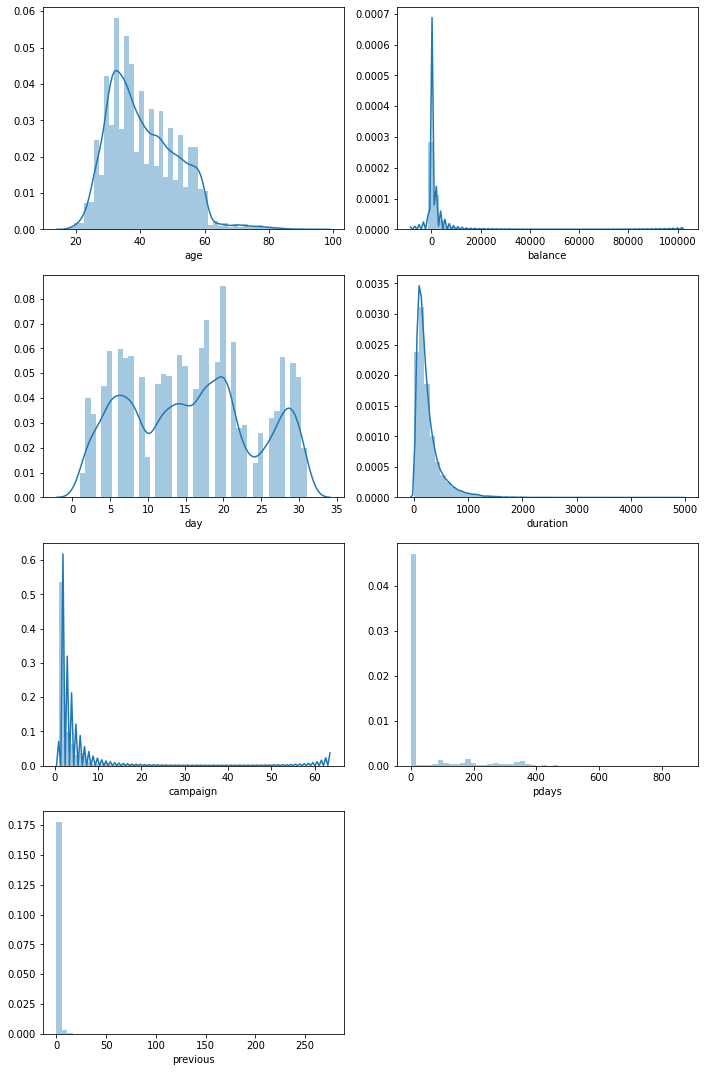

In [12]:
# distribution plot
fig, axe = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
axe = axe.flatten()

for i in range(7):
    sns.distplot(df[number_ft[i]], ax=axe[i])

plt.tight_layout()

axe.flat[-1].set_visible(False)
plt.show()

In [13]:
# Distribution of the categorical feature with count plotb

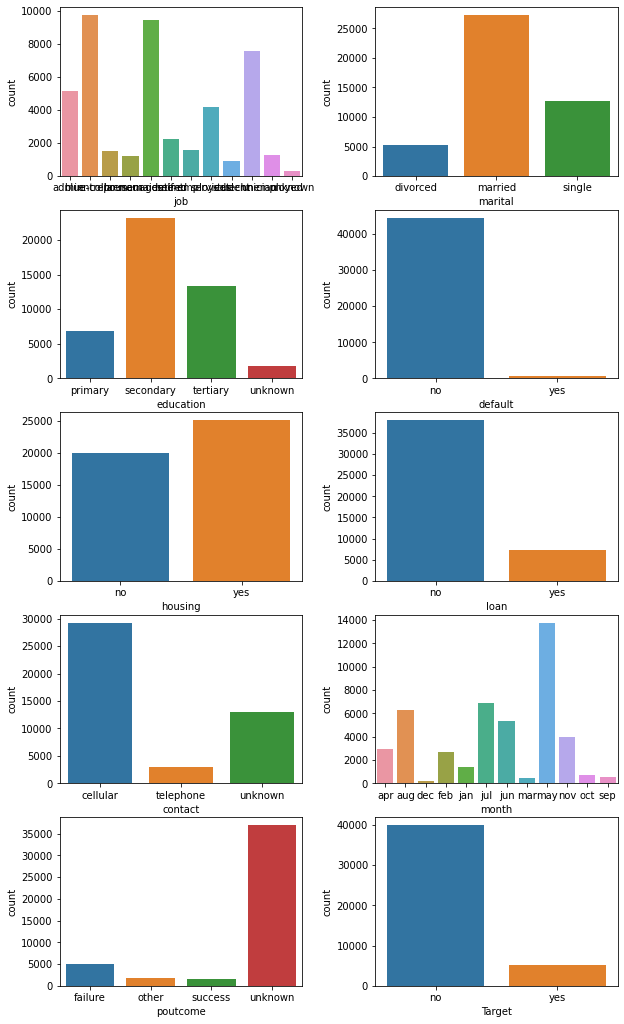

In [14]:
fig, axe = plt.subplots(nrows=5, ncols=2, figsize=(10, 18))
fig.subplots_adjust(wspace=0.3)
axe = axe.flatten()

for i in range(10):
    sns.countplot(df[obj_ft[i]], ax=axe[i])

In [15]:
# more than 90% customers have no defaults
# we can see the target ft is unbalance, more than 80% have not subscribed
# most of the customers have been contacted in month of May

In [16]:
# measure of the skewness of numeric features

df.skew().to_frame('Skewness Measure')

,Skewness Measure
age,0.684818
balance,8.360308
day,0.093079
duration,3.144318
campaign,4.898650
pdays,2.615715
previous,41.846454


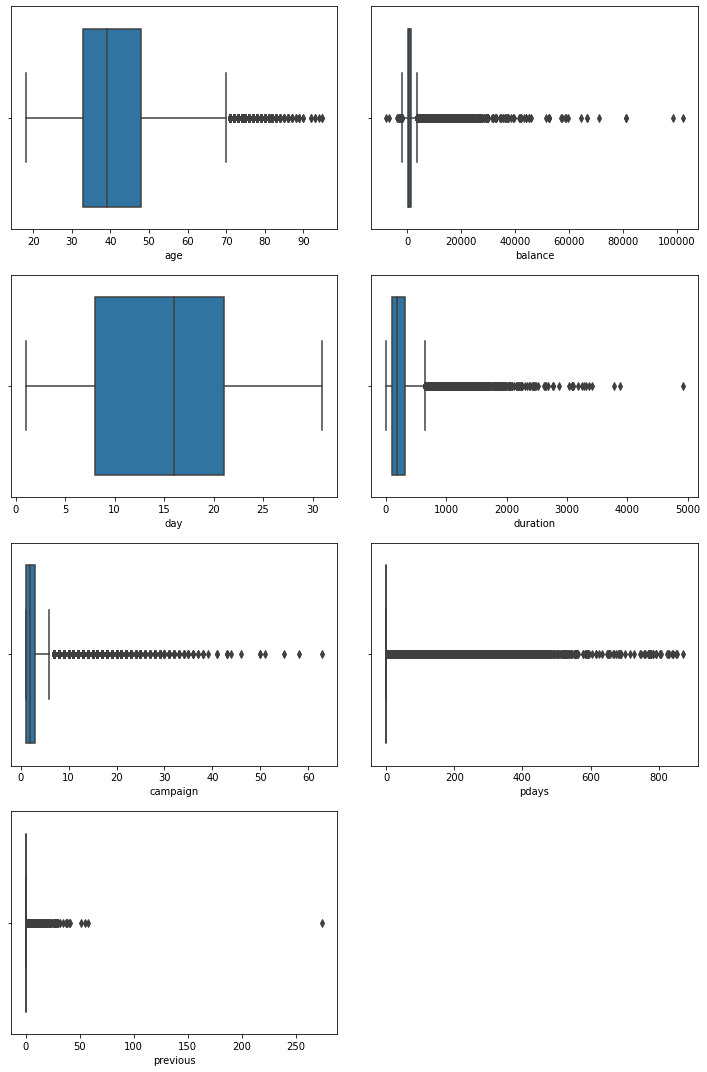

In [17]:
# box plot for checking the outliers

fig, axe = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))
axe = axe.flatten()

for i in range(7):
    sns.boxplot(df[number_ft[i]], ax=axe[i])

plt.tight_layout()

axe.flat[-1].set_visible(False)
plt.show()

In [46]:
# encode the categorical feature into integers

df2 = df.copy()
encoder = LabelEncoder()

obj_ft2 = obj_ft.tolist()
obj_ft2.remove('contact')
obj_ft2.remove('job')

In [47]:
for i in obj_ft2:
    df2[i] = encoder.fit_transform(df2[i]).astype(int)

In [48]:
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,1,2,0,2143,1,0,unknown,5,8,261,1,-1,0,3,0
1,44,technician,2,1,0,29,1,0,unknown,5,8,151,1,-1,0,3,0
2,33,entrepreneur,1,1,0,2,1,1,unknown,5,8,76,1,-1,0,3,0
3,47,blue-collar,1,3,0,1506,1,0,unknown,5,8,92,1,-1,0,3,0
4,33,unknown,2,3,0,1,0,0,unknown,5,8,198,1,-1,0,3,0


In [49]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  int64   
 3   education  45211 non-null  int64   
 4   default    45211 non-null  int64   
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  int64   
 7   loan       45211 non-null  int64   
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  int64   
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  int64   
 16  Target     45211 non-null  int64   
dtypes: category(2), int64(15)
memory usage: 5.3 MB


In [50]:
# convert to caterogical feature
df2[obj_ft] = df2[obj_ft].apply(pd.Categorical)

In [53]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  Target     45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [57]:
## handling outliers with mean replacement
# balance, duration, campaign, pdays, previous from these features

outlier_ft = number_ft.copy()
outlier_ft.remove('age')
outlier_ft.remove('day')

outlier_ft

['balance', 'duration', 'campaign', 'pdays', 'previous']

In [58]:
for i in outlier_ft:
    mean = float(df2[i].mean())
    df2[i] = np.where(df2[i] > np.percentile(df2[i], 75), mean, df2[i])

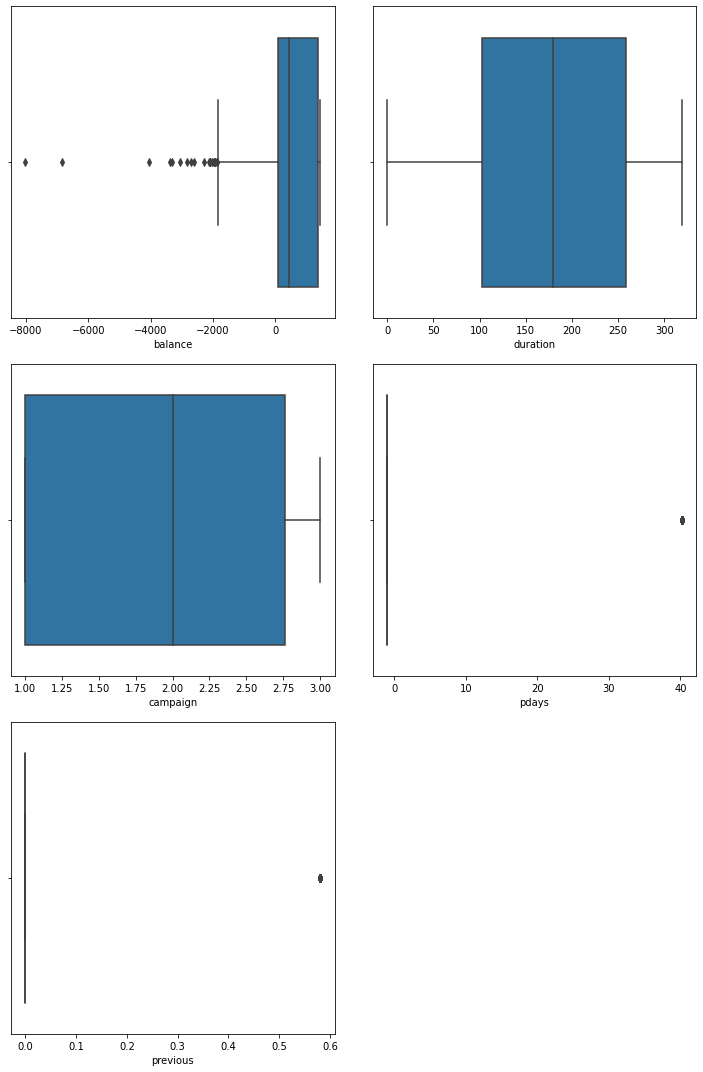

In [62]:
# checking outliers after we remove it
# box plot for checking the outliers

fig, axe = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axe = axe.flatten()

for i in range(5):
    sns.boxplot(df2[outlier_ft[i]], ax=axe[i])

plt.tight_layout()

axe.flat[-1].set_visible(False)
plt.show()

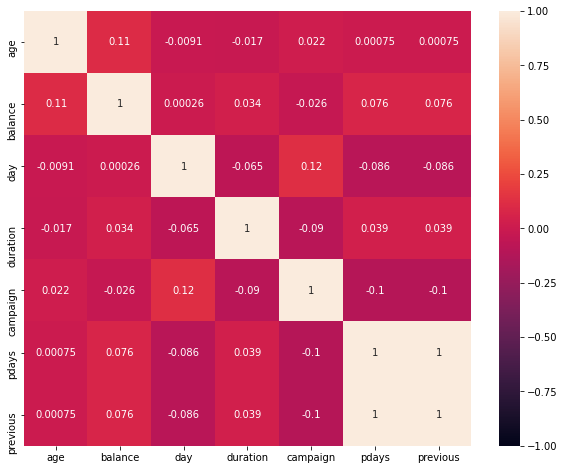

In [71]:
# Correlation Plot of all Features

plt.figure(figsize =(10,8))
sns.heatmap(df2.corr(), annot=True, vmax=1, vmin=-1)
plt.show()

In [72]:
## drop the unnecessary features job, education,contact, duration, pdays, day, month

df2.drop(['job', 'education','contact', 'duration', 'pdays', 'day', 'month'],axis =1, inplace=True)

In [73]:
df2.head()

,age,marital,default,balance,housing,loan,campaign,previous,poutcome,Target
0,58,1,0,1362.272058,1,0,1.0,0.0,3,0
1,44,2,0,29.000000,1,0,1.0,0.0,3,0
2,33,1,0,2.000000,1,1,1.0,0.0,3,0
3,47,1,0,1362.272058,1,0,1.0,0.0,3,0
4,33,2,0,1.000000,0,0,1.0,0.0,3,0


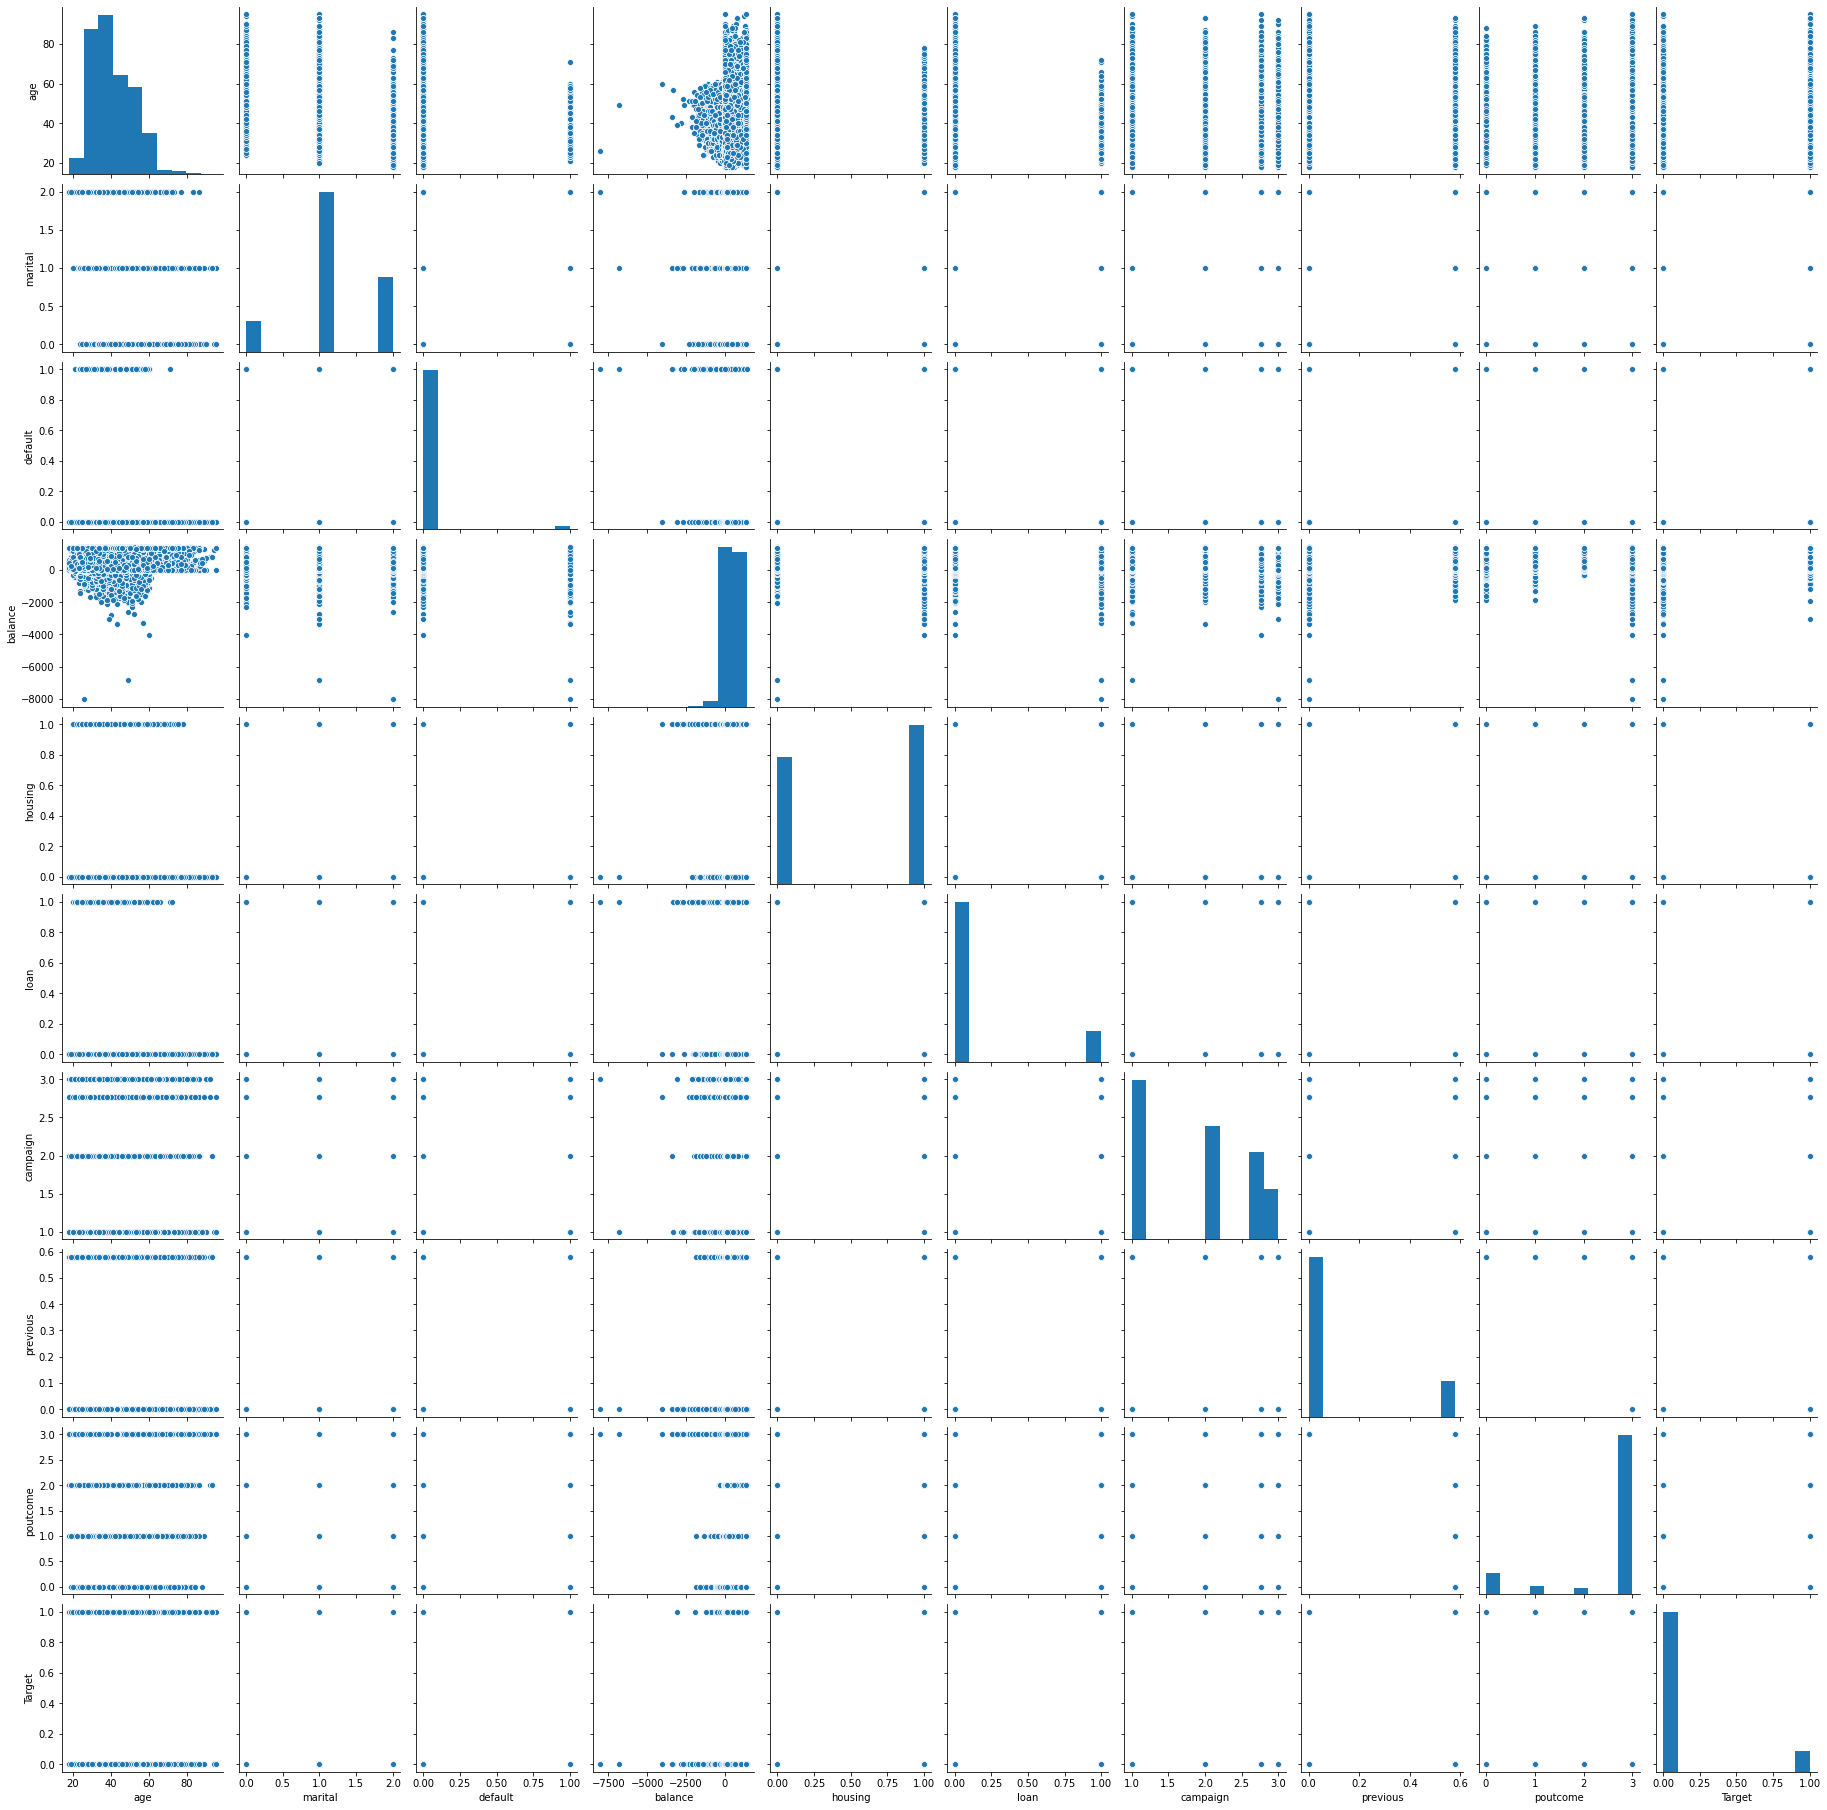

In [74]:
## pairplot of the features

sns.pairplot(df2)

In [75]:
# split data for training and testing (70 : 30)

X = df2.drop('Target', axis =1)
y = df2.Target

In [76]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state =2)

In [77]:
# Scaling the data
scale = StandardScaler()

xtrain_scaled = scale.fit_transform(xtrain)
xtest_scaled = scale.fit_transform(xtest) 

## Build the models

In [81]:
# logistic regression

lr = LogisticRegression(solver='liblinear')
lr.fit(xtrain_scaled, ytrain)
ypred_lr= lr.predict(xtest_scaled)

lr_acc = accuracy_score(ytest, ypred_lr)
lr_cm = confusion_matrix(ytest, ypred_lr)
lr_cr = classification_report(ytest, ypred_lr)
print(lr_acc*100)
print(lr_cm)
print(lr_cr)

89.49424948392804
[[11892   107]
 [ 1318   247]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11999
           1       0.70      0.16      0.26      1565

    accuracy                           0.89     13564
   macro avg       0.80      0.57      0.60     13564
weighted avg       0.88      0.89      0.86     13564



In [80]:
# naive bayes

nb = GaussianNB()
nb.fit(xtrain_scaled, ytrain)
ypred_nb= nb.predict(xtest_scaled)

nb_acc = accuracy_score(ytest, ypred_nb)
nb_cm = confusion_matrix(ytest, ypred_nb)
nb_cr = classification_report(ytest, ypred_nb)
print(nb_acc*100)
print(nb_cm)
print(nb_cr)

82.40194632851666
[[10667  1332]
 [ 1055   510]]
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     11999
           1       0.28      0.33      0.30      1565

    accuracy                           0.82     13564
   macro avg       0.59      0.61      0.60     13564
weighted avg       0.84      0.82      0.83     13564



In [88]:
# knn

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(xtrain_scaled, ytrain)
ypred_knn= knn.predict(xtest_scaled)

knn_acc = accuracy_score(ytest, ypred_knn)
knn_cm = confusion_matrix(ytest, ypred_knn)
knn_cr = classification_report(ytest, ypred_knn)
print(knn_acc*100)
print(knn_cm)
print(knn_cr)

88.60218224712474
[[11735   264]
 [ 1282   283]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11999
           1       0.52      0.18      0.27      1565

    accuracy                           0.89     13564
   macro avg       0.71      0.58      0.60     13564
weighted avg       0.86      0.89      0.86     13564



In [89]:
# svc

svc = SVC()
svc.fit(xtrain_scaled, ytrain)
ypred_svc = svc.predict(xtest_scaled)

svc_acc = accuracy_score(ytest, ypred_svc)
svc_cm = confusion_matrix(ytest, ypred_svc)
svc_cr = classification_report(ytest, ypred_svc)
print(svc_acc*100)
print(svc_cm)
print(svc_cr)

89.45738720141551
[[11856   143]
 [ 1287   278]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11999
           1       0.66      0.18      0.28      1565

    accuracy                           0.89     13564
   macro avg       0.78      0.58      0.61     13564
weighted avg       0.87      0.89      0.87     13564



In [109]:
# decision tree

dt = DecisionTreeClassifier(criterion='gini', random_state= 1, max_features=4dd)
dt.fit(xtrain_scaled, ytrain)
ypred_dt = dt.predict(xtest_scaled)

dt_acc = accuracy_score(ytest, ypred_dt)
dt_cm = confusion_matrix(ytest, ypred_dt)
dt_cr = classification_report(ytest, ypred_dt)
print(dt_acc*100)
print(dt_cm)
print(dt_cr)

83.30875847832498
[[10918  1081]
 [ 1183   382]]
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     11999
           1       0.26      0.24      0.25      1565

    accuracy                           0.83     13564
   macro avg       0.58      0.58      0.58     13564
weighted avg       0.83      0.83      0.83     13564



In [102]:
#feature importance for dt
ft_score = dt.feature_importances_
df_dt = pd.DataFrame({'Feature': xtrain.columns, 'ft_score': ft_score})
df_dt.sort_values(by='ft_score', ascending =False)

,Feature,ft_score
3,balance,0.444273
0,age,0.260087
8,poutcome,0.091608
6,campaign,0.072900
1,marital,0.042087
7,previous,0.034786
5,loan,0.028816
4,housing,0.020604
2,default,0.004840


In [111]:
# Bagging Ensemble 

bagc = BaggingClassifier(base_estimator= dt, n_estimators= 500, random_state=1)
bagc.fit(xtrain_scaled, ytrain)
bagc_pred = bagc.predict(xtest_scaled)

bagc_acc = accuracy_score(ytest, bagc_pred)
bagc_cm = confusion_matrix(ytest, bagc_pred)
bagc_cr = classification_report(ytest, bagc_pred)
print(bagc_acc*100)
print(bagc_cm)
print(bagc_cr)

87.48894131524624
[[11525   474]
 [ 1223   342]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     11999
           1       0.42      0.22      0.29      1565

    accuracy                           0.87     13564
   macro avg       0.66      0.59      0.61     13564
weighted avg       0.85      0.87      0.86     13564



In [120]:
# adaptive boost

adac = AdaBoostClassifier(n_estimators= 150, random_state=9)
adac.fit(xtrain_scaled, ytrain)
adac_pred = adac.predict(xtest_scaled)

adac_acc = accuracy_score(ytest, adac_pred)
adac_cm = confusion_matrix(ytest, adac_pred)
adac_cr = classification_report(ytest, adac_pred)
print(adac_acc*100)
print(adac_cm)
print(adac_cr)

89.37629017988795
[[11874   125]
 [ 1316   249]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11999
           1       0.67      0.16      0.26      1565

    accuracy                           0.89     13564
   macro avg       0.78      0.57      0.60     13564
weighted avg       0.87      0.89      0.86     13564



In [125]:
# random forest

rfc = RandomForestClassifier(n_estimators= 150, random_state=1, max_features=3)
rfc.fit(xtrain_scaled, ytrain)
rfc_pred = rfc.predict(xtest_scaled)

rfc_acc = accuracy_score(ytest, rfc_pred)
rfc_cm = confusion_matrix(ytest, rfc_pred)
rfc_cr = classification_report(ytest, rfc_pred)
print(rfc_acc*100)
print(rfc_cm)
print(rfc_cr)

87.46682394573872
[[11525   474]
 [ 1226   339]]
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     11999
           1       0.42      0.22      0.29      1565

    accuracy                           0.87     13564
   macro avg       0.66      0.59      0.61     13564
weighted avg       0.85      0.87      0.86     13564



In [128]:
rfc.feature_importances_

array([0.30215584, 0.02810246, 0.00280186, 0.46314229, 0.03254566,
       0.01425852, 0.04923181, 0.02150057, 0.08626099])

In [130]:
# gradient bossting

gbc = GradientBoostingClassifier(n_estimators= 220, random_state=1)
gbc.fit(xtrain_scaled, ytrain)
gbc_pred = gbc.predict(xtest_scaled)

gbc_acc = accuracy_score(ytest, gbc_pred)
gbc_cm = confusion_matrix(ytest, gbc_pred)
gbc_cr = classification_report(ytest, gbc_pred)
print(gbc_acc*100)
print(gbc_cm)
print(gbc_cr)

89.41315246240048
[[11892   107]
 [ 1329   236]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11999
           1       0.69      0.15      0.25      1565

    accuracy                           0.89     13564
   macro avg       0.79      0.57      0.60     13564
weighted avg       0.88      0.89      0.86     13564



In [163]:
scores = {'NaiveBayes' : nb_acc,
         'LogisticReg' : lr_acc,
         'KNN' : knn_acc,
         'SVC' : svc_acc,
         'DecisionTree' : dt_acc,
         'Bagging' : bagc_acc,
         'AdaBoost': adac_acc,
         'GradientBoost': gbc_acc,
         'RFC' : rfc_acc,
         }

df_scores = pd.DataFrame.from_dict(scores, orient= 'index', columns=['Score'])
df_scores.reset_index(inplace=True)
df_scores.rename(columns = {'index': 'Model'}, inplace=True)
df_scores.sort_values(by = 'Score', ascending=False)

,Model,Score
1,LogisticReg,0.894942
3,SVC,0.894574
7,GradientBoost,0.894132
6,AdaBoost,0.893763
2,KNN,0.886022
5,Bagging,0.874889
8,RFC,0.874668
4,DecisionTree,0.833088
0,NaiveBayes,0.824019
